<a href="https://colab.research.google.com/github/xygu/bert_explore/blob/main/Chapter11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 11

## Additional Setup

The repository for the `allennlp` library has been archived. The library was used by `flair` to provide ELMO embeddings. This required PyTorch to be downgraded to version 1.7.1, and it prevented updating other libraries used in this chapter.

At this point, the sensible solution is to upgrade `flair` and the other packages to more up-to-date versions and retire the use of ELMO embeddings. For the sake of completion, these embeddings will be replaced by flair embeddings in the code. Some code will be commented out whenever the replacement produces results that are substantially different from those produced by ELMO.

Moreover, upgrading the `gensim` library required a few changes in the code since some attributes were changed from its 3.8.3 to its 4.3.3 version. These changes are highlighted in the code.

**IMPORTANT**: due to the major version upgrade, the output of several cells will be quite different than those shown in the book. The new Gensim version produces slightly different vocabularies, so you should expect small changes in the number of words in the vocabulary, for example.

In [1]:
# UPDATED
###########################################################
!pip install gensim==4.3.3
# The library has been archived and won't be used anymore
# # !pip install allennlp==0.9.0
!pip install flair==0.13.1
!pip install torchvision==0.18.1
# # HuggingFace
!pip install transformers==4.37.2
!pip install accelerate==0.28.0
!pip install datasets==2.18.0
###########################################################

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter11()
# This is needed to render the plots in this chapter
from plots.chapter11 import *

Finished!


In [3]:
import os
import json
import errno
import requests
import numpy as np
from copy import deepcopy
from operator import itemgetter

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

from data_generation.nlp import ALICE_URL, WIZARD_URL, download_text
from stepbystep.v4 import StepByStep
# These are the classes we built in Chapter 10
from seq2seq import *

import nltk
from nltk.tokenize import sent_tokenize

In [248]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
import gensim
from gensim import corpora, downloader
from gensim.parsing.preprocessing import *
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

In [5]:
from flair.data import Sentence
#from flair.embeddings import ELMoEmbeddings, WordEmbeddings, \
#    TransformerWordEmbeddings, TransformerDocumentEmbeddings
from flair.embeddings import WordEmbeddings, \
    TransformerWordEmbeddings, TransformerDocumentEmbeddings

In [6]:
from datasets import load_dataset, Split
from transformers import (
    DataCollatorForLanguageModeling,
    BertModel, BertTokenizer, BertForSequenceClassification,
    DistilBertModel, DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AutoModelForSequenceClassification,
    AutoModel, AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments, pipeline, TextClassificationPipeline
)
from transformers.pipelines import SUPPORTED_TASKS

# Down the Yellow Brick Rabbit Hole

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/alice_dorothy.png?raw=1)

*Left: "Alice and the Baby Pig" illustration by John Tenniel's, from "Alice's Adventure's in Wonderland" (1865).*

*Right: "Dorothy meets the Cowardly Lion" illustration by W.W. Denslow, from "The Wonderful Wizard of Oz" (1900)*

# Building a Dataset

In [7]:
localfolder = 'texts'
download_text(ALICE_URL, localfolder)
download_text(WIZARD_URL, localfolder)

In [8]:
with open(os.path.join(localfolder, 'alice28-1476.txt'), 'r') as f:
    alice = ''.join(f.readlines()[104:3704])

with open(os.path.join(localfolder, 'wizoz10-1740.txt'), 'r') as f:
    wizard = ''.join(f.readlines()[310:5100])

In [9]:
print(alice[:500])
print('\n')
print(wizard[:500])

                ALICE'S ADVENTURES IN WONDERLAND

                          Lewis Carroll

               THE MILLENNIUM FULCRUM EDITION 2.8




                            CHAPTER I

                      Down the Rabbit-Hole


  Alice was beginning to get very tired of sitting by her sister
on the bank, and of having nothing to do:  once or twice she had
peeped into the book her sister was reading, but it had no
pictures or conversations in it, `and what is the use of a book,'
thought Alice `w


                    THE WONDERFUL WIZARD OF OZ


                          1.  The Cyclone


    Dorothy lived in the midst of the great Kansas prairies, with
Uncle Henry, who was a farmer, and Aunt Em, who was the farmer's
wife.  Their house was small, for the lumber to build it had to be
carried by wagon many miles.  There were four walls, a floor and a
roof, which made one room; and this room contained a rusty looking
cookstove, a cupboard for the dishes, a table, three or four
chairs, and

In [10]:
text_cfg = """fname,start,end
alice28-1476.txt,104,3704
wizoz10-1740.txt,310,5100"""
bytes_written = open(os.path.join(localfolder, 'lines.cfg'), 'w').write(text_cfg)

## Sentence Tokenization

In [11]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(' ')
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

In [12]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
corpus_alice = sent_tokenize(alice)
corpus_wizard = sent_tokenize(wizard)
len(corpus_alice), len(corpus_wizard)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(1612, 2240)

In [13]:
corpus_alice[2]

'There was nothing so VERY remarkable in that; nor did Alice\nthink it so VERY much out of the way to hear the Rabbit say to\nitself, `Oh dear!'

In [14]:
corpus_wizard[30]

'"There\'s a cyclone coming, Em," he called to his wife.'

In [15]:
def sentence_tokenize(source, quote_char='\\', sep_char=',',
                      include_header=True, include_source=True,
                      extensions=('txt'), **kwargs):
    nltk.download('punkt')
    # If source is a folder, goes through all files inside it
    # that match the desired extensions ('txt' by default)
    if os.path.isdir(source):
        filenames = [f for f in os.listdir(source)
                     if os.path.isfile(os.path.join(source, f)) and
                        os.path.splitext(f)[1][1:] in extensions]
    elif isinstance(source, str):
        filenames = [source]

    # If there is a configuration file, builds a dictionary with
    # the corresponding start and end lines of each text file
    config_file = os.path.join(source, 'lines.cfg')
    config = {}
    if os.path.exists(config_file):
        with open(config_file, 'r') as f:
            rows = f.readlines()

        for r in rows[1:]:
            fname, start, end = r.strip().split(',')
            config.update({fname: (int(start), int(end))})

    new_fnames = []
    # For each file of text
    for fname in filenames:
        # If there's a start and end line for that file, use it
        try:
            start, end = config[fname]
        except KeyError:
            start = None
            end = None

        # Opens the file, slices the configures lines (if any)
        # cleans line breaks and uses the sentence tokenizer
        with open(os.path.join(source, fname), 'r') as f:
            contents = (''.join(f.readlines()[slice(start, end, None)])
                        .replace('\n', ' ').replace('\r', ''))
        corpus = sent_tokenize(contents, **kwargs)

        # Builds a CSV file containing tokenized sentences
        base = os.path.splitext(fname)[0]
        new_fname = f'{base}.sent.csv'
        new_fname = os.path.join(source, new_fname)
        with open(new_fname, 'w') as f:
            # Header of the file
            if include_header:
                if include_source:
                    f.write('sentence,source\n')
                else:
                    f.write('sentence\n')
            # Writes one line for each sentence
            for sentence in corpus:
                if include_source:
                    f.write(f'{quote_char}{sentence}{quote_char}{sep_char}{fname}\n')
                else:
                    f.write(f'{quote_char}{sentence}{quote_char}\n')
        new_fnames.append(new_fname)

    # Returns list of the newly generated CSV files
    return sorted(new_fnames)

In [16]:
new_fnames = sentence_tokenize(localfolder)
new_fnames

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['texts/alice28-1476.sent.csv', 'texts/wizoz10-1740.sent.csv']

In [17]:
# import spacy
# nlp = spacy.blank("en")
# nlp.add_pipe(nlp.create_pipe("sentencizer"))

# sentences = []
# for doc in nlp.pipe(corpus_alice):
#     sentences.extend(sent.text for sent in doc.sents)

# len(sentences), sentences[2]

## HuggingFace's Dataset

## Loading a Dataset

In [18]:
from datasets import load_dataset, Split

dataset = load_dataset(path='csv', data_files=new_fnames, quotechar='\\', split=Split.TRAIN)

Generating train split: 0 examples [00:00, ? examples/s]

### Attributes

In [19]:
dataset.features, dataset.num_columns, dataset.shape

({'sentence': Value(dtype='string', id=None),
  'source': Value(dtype='string', id=None)},
 2,
 (3852, 2))

In [20]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt'}

In [21]:
dataset['source'][:3]

['alice28-1476.txt', 'alice28-1476.txt', 'alice28-1476.txt']

### Methods

In [22]:
dataset.unique('source')

['alice28-1476.txt', 'wizoz10-1740.txt']

In [23]:
def is_alice_label(row):
    is_alice = int(row['source'] == 'alice28-1476.txt')
    return {'labels': is_alice}

dataset = dataset.map(is_alice_label)

Map:   0%|          | 0/3852 [00:00<?, ? examples/s]

In [24]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt',
 'labels': 1}

In [25]:
shuffled_dataset = dataset.shuffle(seed=42)

In [26]:
split_dataset = shuffled_dataset.train_test_split(test_size=0.2)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'source', 'labels'],
        num_rows: 3081
    })
    test: Dataset({
        features: ['sentence', 'source', 'labels'],
        num_rows: 771
    })
})

In [27]:
train_dataset, test_dataset = split_dataset['train'], split_dataset['test']

## Data Augmentation

In [28]:
# !pip install textattack
# from textattack.augmentation import EmbeddingAugmenter
# augmenter = EmbeddingAugmenter()
# feynman = 'What I cannot create, I do not understand.'

In [29]:
# for i in range(5):
#     print(augmenter.augment(feynman))

# Word Tokenization

In [30]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(' ')
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

In [31]:
from gensim.parsing.preprocessing import *

preprocess_string(sentence)

['follow', 'white', 'rabbit']

In [32]:
filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric]
preprocess_string(sentence, filters=filters)

['i', 'm', 'following', 'the', 'white', 'rabbit']

In [33]:
from gensim.utils import simple_preprocess

tokens = simple_preprocess(sentence)
tokens

['following', 'the', 'white', 'rabbit']

## Vocabulary

In [34]:
sentences = train_dataset['sentence']
tokens = [simple_preprocess(sent) for sent in sentences]
tokens[0]

['they', 'walked', 'back', 'to', 'the', 'road']

In [35]:
from gensim import corpora

dictionary = corpora.Dictionary(tokens)
print(dictionary)

Dictionary<3705 unique tokens: ['back', 'road', 'the', 'they', 'to']...>


In [36]:
dictionary.num_docs

3081

In [37]:
dictionary.num_pos # processed words

50826

In [38]:
dictionary.token2id

{'back': 0,
 'road': 1,
 'the': 2,
 'they': 3,
 'to': 4,
 'walked': 5,
 'give': 6,
 'heart': 7,
 'me': 8,
 'or': 9,
 'said': 10,
 'tin': 11,
 'woodman': 12,
 'and': 13,
 'caterpillar': 14,
 'hookah': 15,
 'in': 16,
 'its': 17,
 'itself': 18,
 'minute': 19,
 'mouth': 20,
 'of': 21,
 'once': 22,
 'out': 23,
 'shook': 24,
 'took': 25,
 'twice': 26,
 'two': 27,
 'yawned': 28,
 'cats': 29,
 'didn': 30,
 'forgot': 31,
 'like': 32,
 'quite': 33,
 'you': 34,
 'an': 35,
 'else': 36,
 'have': 37,
 'honest': 38,
 'man': 39,
 'meant': 40,
 'mischief': 41,
 'must': 42,
 'name': 43,
 'signed': 44,
 'some': 45,
 'your': 46,
 'hatter': 47,
 'all': 48,
 'anyone': 49,
 'good': 50,
 'help': 51,
 'her': 52,
 'hurt': 53,
 'known': 54,
 'magic': 55,
 'never': 56,
 'people': 57,
 'she': 58,
 'used': 59,
 'was': 60,
 'who': 61,
 'alice': 62,
 'asked': 63,
 'curiosity': 64,
 'great': 65,
 'tone': 66,
 'but': 67,
 'head': 68,
 'his': 69,
 'king': 70,
 'monkey': 71,
 'am': 72,
 'get': 73,
 'how': 74,
 'please': 

In [39]:
vocab = list(dictionary.token2id.keys())
vocab[:5]

['back', 'road', 'the', 'they', 'to']

In [40]:
dictionary.cfs

{3: 431,
 5: 43,
 0: 116,
 4: 1490,
 2: 3688,
 1: 37,
 9: 94,
 6: 43,
 8: 207,
 7: 61,
 10: 628,
 11: 112,
 12: 142,
 16: 659,
 19: 22,
 27: 51,
 14: 23,
 25: 42,
 15: 4,
 23: 182,
 21: 1079,
 17: 70,
 20: 21,
 13: 2004,
 28: 3,
 22: 73,
 26: 6,
 24: 13,
 18: 14,
 33: 73,
 31: 3,
 34: 700,
 30: 17,
 32: 131,
 29: 12,
 42: 87,
 37: 195,
 40: 5,
 45: 66,
 41: 3,
 36: 13,
 44: 2,
 46: 103,
 43: 12,
 35: 76,
 38: 1,
 39: 63,
 47: 51,
 48: 352,
 52: 533,
 55: 9,
 60: 699,
 59: 16,
 51: 40,
 57: 62,
 58: 773,
 56: 87,
 54: 7,
 53: 18,
 49: 9,
 61: 147,
 50: 102,
 62: 319,
 63: 102,
 66: 34,
 65: 143,
 64: 3,
 67: 375,
 71: 7,
 70: 75,
 69: 258,
 68: 110,
 75: 26,
 76: 187,
 74: 124,
 72: 80,
 73: 106,
 77: 34,
 78: 4,
 84: 40,
 81: 362,
 82: 6,
 83: 84,
 79: 3,
 80: 10,
 85: 141,
 86: 11,
 88: 78,
 89: 39,
 91: 88,
 90: 14,
 87: 25,
 105: 138,
 98: 286,
 99: 30,
 104: 98,
 96: 46,
 94: 65,
 102: 124,
 100: 127,
 92: 65,
 103: 11,
 93: 371,
 95: 6,
 101: 11,
 97: 24,
 107: 110,
 106: 103,
 11

In [41]:
dictionary.dfs

{3: 333,
 5: 43,
 0: 115,
 4: 1096,
 2: 1868,
 1: 35,
 9: 83,
 6: 43,
 8: 181,
 7: 56,
 10: 617,
 11: 112,
 12: 139,
 16: 570,
 19: 22,
 27: 50,
 14: 21,
 25: 41,
 15: 4,
 23: 176,
 21: 807,
 17: 57,
 20: 21,
 13: 1302,
 28: 3,
 22: 71,
 26: 6,
 24: 13,
 18: 12,
 33: 68,
 31: 3,
 34: 541,
 30: 16,
 32: 124,
 29: 11,
 42: 84,
 37: 181,
 40: 5,
 45: 63,
 41: 3,
 36: 13,
 44: 2,
 46: 99,
 43: 12,
 35: 73,
 38: 1,
 39: 61,
 47: 51,
 48: 323,
 52: 386,
 55: 9,
 60: 557,
 59: 16,
 51: 39,
 57: 62,
 58: 511,
 56: 83,
 54: 7,
 53: 18,
 49: 9,
 61: 143,
 50: 95,
 62: 310,
 63: 102,
 66: 34,
 65: 141,
 64: 3,
 67: 364,
 71: 7,
 70: 72,
 69: 212,
 68: 102,
 75: 26,
 76: 180,
 74: 116,
 72: 72,
 73: 104,
 77: 31,
 78: 4,
 84: 36,
 81: 312,
 82: 6,
 83: 81,
 79: 3,
 80: 10,
 85: 133,
 86: 11,
 88: 77,
 89: 39,
 91: 84,
 90: 14,
 87: 25,
 105: 118,
 98: 269,
 99: 29,
 104: 92,
 96: 46,
 94: 64,
 102: 118,
 100: 126,
 92: 65,
 103: 11,
 93: 333,
 95: 6,
 101: 11,
 97: 24,
 107: 109,
 106: 98,
 111: 3

In [42]:
sentence = 'follow the white rabbit'
new_tokens = simple_preprocess(sentence)
ids = dictionary.doc2idx(new_tokens)
print(new_tokens)
print(ids)

['follow', 'the', 'white', 'rabbit']
[2713, 2, 282, 534]


In [43]:
special_tokens = {'[PAD]': 0, '[UNK]': 1}
dictionary.patch_with_special_tokens(special_tokens)

In [44]:
def get_rare_ids(dictionary, min_freq):
    rare_ids = [t[0] for t in dictionary.cfs.items() if t[1] < min_freq]
    return rare_ids

In [45]:
def make_vocab(sentences, folder=None, special_tokens=None, vocab_size=None, min_freq=None):
    if folder is not None:
        if not os.path.exists(folder):
            os.mkdir(folder)

    # tokenizes the sentences and create a Dictionary
    tokens = [simple_preprocess(sent) for sent in sentences]
    dictionary = corpora.Dictionary(tokens)
    # keeps only the most frequent words (vocab size)
    if vocab_size is not None:
        dictionary.filter_extremes(keep_n=vocab_size)
    # removes rare words (in case the vocab size still
    # includes words with low frequency)
    if min_freq is not None:
        rare_tokens = get_rare_ids(dictionary, min_freq)
        dictionary.filter_tokens(bad_ids=rare_tokens)
    # gets the whole list of tokens and frequencies
    items = dictionary.cfs.items()
    # sorts the tokens in descending order
    words = [dictionary[t[0]] for t in sorted(dictionary.cfs.items(), key=lambda t: -t[1])]
    # prepends special tokens, if any
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words

    with open(os.path.join(folder, 'vocab.txt'), 'w') as f:
        for word in words:
            f.write(f'{word}\n')

In [46]:
make_vocab(train_dataset['sentence'], 'our_vocab/', special_tokens=['[PAD]', '[UNK]', '[SEP]', '[CLS]', '[MASK]'], min_freq=2)

## HugginFace's Tokenizer

In [47]:
from transformers import BertTokenizer

tokenizer = BertTokenizer('our_vocab/vocab.txt')

In [48]:
new_sentence = 'follow the white rabbit neo'
new_tokens = tokenizer.tokenize(new_sentence)
new_tokens

['follow', 'the', 'white', 'rabbit', '[UNK]']

In [49]:
new_ids = tokenizer.convert_tokens_to_ids(new_tokens)
new_ids

[1324, 5, 221, 201, 1]

In [50]:
new_ids = tokenizer.encode(new_sentence)
new_ids

[3, 1324, 5, 221, 201, 1, 2]

In [51]:
tokenizer.convert_ids_to_tokens(new_ids)

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]']

In [52]:
tokenizer.encode(new_sentence, add_special_tokens=False)

[1324, 5, 221, 201, 1]

In [53]:
tokenizer(new_sentence, add_special_tokens=False, return_tensors='pt')

{'input_ids': tensor([[1324,    5,  221,  201,    1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [54]:
sentence1 = 'follow the white rabbit neo'
sentence2 = 'no one can be told what the matrix is'
joined_sentences = tokenizer(sentence1, sentence2)
joined_sentences

{'input_ids': [3, 1324, 5, 221, 201, 1, 2, 50, 45, 78, 32, 260, 47, 5, 1, 30, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [55]:
print(tokenizer.convert_ids_to_tokens(joined_sentences['input_ids']))

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', 'no', 'one', 'can', 'be', 'told', 'what', 'the', '[UNK]', 'is', '[SEP]']


In [56]:
separate_sentences = tokenizer([sentence1, sentence2], padding=True)
separate_sentences

{'input_ids': [[3, 1324, 5, 221, 201, 1, 2, 0, 0, 0, 0], [3, 50, 45, 78, 32, 260, 47, 5, 1, 30, 2]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [57]:
print(tokenizer.convert_ids_to_tokens(separate_sentences['input_ids'][0]))
print(separate_sentences['attention_mask'][0])

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


In [58]:
first_sentences = [sentence1, 'another first sentence']
second_sentences = [sentence2, 'a second sentence here']
batch_of_pairs = tokenizer(first_sentences, second_sentences)
first_input = tokenizer.convert_ids_to_tokens(batch_of_pairs['input_ids'][0])
second_input = tokenizer.convert_ids_to_tokens(batch_of_pairs['input_ids'][1])
print(first_input)
print(second_input)

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', 'no', 'one', 'can', 'be', 'told', 'what', 'the', '[UNK]', 'is', '[SEP]']
['[CLS]', 'another', 'first', 'sentence', '[SEP]', '[UNK]', 'second', 'sentence', 'here', '[SEP]']


In [59]:
tokenized_dataset = tokenizer(dataset['sentence'],
                              padding=True,
                              return_tensors='pt',
                              max_length=50,
                              truncation=True)
tokenized_dataset['input_ids']

tensor([[   3,   27,    1,  ...,   94,  864,    2],
        [   3,   25,   10,  ..., 1530,    5,    2],
        [   3,   48,   12,  ...,    0,    0,    0],
        ...,
        [   3,    1,    6,  ...,    0,    0,    0],
        [   3,    6,  135,  ...,    0,    0,    0],
        [   3,    1,    1,  ...,    0,    0,    0]])

# Before Word Embeddings

## One-Hot Encoding (OHE)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/ohe1.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/ohe2.png?raw=1)

## Bag of Words (BoW)

In [60]:
sentence = 'the white rabbit is a rabbit'
bow_tokens = simple_preprocess(sentence)
bow_tokens

['the', 'white', 'rabbit', 'is', 'rabbit']

In [61]:
bow = dictionary.doc2bow(bow_tokens)
bow

[(2, 1), (224, 1), (282, 1), (534, 2)]

## Language Models

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/blank1.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/blank2.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/fill1.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/fill2.png?raw=1)

## N-grams

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/ngrams.png?raw=1)

## Continuous Bag-of-Words (CBoW)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/blank_end.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/blank_center.png?raw=1)

# Word Embeddings

## Word2Vec

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/cbow.png?raw=1)

In [62]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, X):
        embeddings = self.embedding(X)
        bow = embeddings.mean(dim=1)
        logits = self.linear(bow)
        return logits

In [63]:
torch.manual_seed(42)
dummy_cbow = CBOW(vocab_size=5, embedding_size=3)
dummy_cbow.embedding.state_dict()

OrderedDict([('weight',
              tensor([[ 0.3367,  0.1288,  0.2345],
                      [ 0.2303, -1.1229, -0.1863],
                      [ 2.2082, -0.6380,  0.4617],
                      [ 0.2674,  0.5349,  0.8094],
                      [ 1.1103, -1.6898, -0.9890]]))])

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/w2v_embed.png?raw=1)

In [64]:
# tokens: ['is', 'barking']
dummy_cbow.embedding(torch.as_tensor([2, 3]))

tensor([[ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094]], grad_fn=<EmbeddingBackward0>)

In [65]:
tiny_vocab = ['the', 'small', 'is', 'barking', 'dog']
context_words = ['the', 'small', 'is', 'barking']
target_words = ['dog']

In [66]:
batch_context = torch.as_tensor([[0, 1, 2, 3]]).long()
batch_target = torch.as_tensor([4]).long()

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/w2v_cbow.png?raw=1)

In [67]:
cbow_features = dummy_cbow.embedding(batch_context).mean(dim=1)
cbow_features

tensor([[ 0.7606, -0.2743,  0.3298]], grad_fn=<MeanBackward1>)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/w2v_logits.png?raw=1)

In [68]:
logits = dummy_cbow.linear(cbow_features)
logits

tensor([[ 0.3542,  0.6937, -0.2028, -0.5873,  0.2099]],
       grad_fn=<AddmmBackward0>)

## What is an Embeddings Anyway?

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/rest_discrete.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/rest_continuous.png?raw=1)

In [69]:
ratings = torch.as_tensor([[.7, -.4, .7],
                           [.3, .7, -.5],
                           [.9, -.55, .8],
                           [-.3, .8, .34]]).float()
sims = torch.zeros(4, 4)
for i in range(4):
    for j in range(4):
        sims[i, j] = F.cosine_similarity(ratings[i], ratings[j], dim=0)
sims

tensor([[ 1.0000, -0.4318,  0.9976, -0.2974],
        [-0.4318,  1.0000, -0.4270,  0.3581],
        [ 0.9976, -0.4270,  1.0000, -0.3598],
        [-0.2974,  0.3581, -0.3598,  1.0000]])

## Pre-trained Word2Vec

## Global Vectors (GloVe)

In [70]:
from gensim import downloader

glove = downloader.load('glove-wiki-gigaword-50')

# UPDATED
###########################################################
# The vocab property isn't available anymore at the newer
# Gensim version. It was replaced by key_to_index
# len(glove.vocab)
len(glove.key_to_index)
###########################################################

400000

In [71]:
glove['alice']

array([ 0.16386 ,  0.57795 , -0.59197 , -0.32446 ,  0.29762 ,  0.85151 ,
       -0.76695 , -0.20733 ,  0.21491 , -0.51587 , -0.17517 ,  0.94459 ,
        0.12705 , -0.33031 ,  0.75951 ,  0.44449 ,  0.16553 , -0.19235 ,
        0.065533, -0.12394 ,  0.61446 ,  0.89784 ,  0.17413 ,  0.41149 ,
        1.191   , -0.39461 , -0.459   ,  0.022161, -0.50843 , -0.44464 ,
        0.68721 , -0.7167  ,  0.20835 , -0.23437 ,  0.02604 , -0.47993 ,
        0.31873 , -0.29135 ,  0.50273 , -0.55144 , -0.066692,  0.43873 ,
       -0.24293 , -1.0247  ,  0.029375,  0.068499,  0.25451 , -1.9663  ,
        0.26673 ,  0.88486 ], dtype=float32)

In [72]:
synthetic_queen = glove['king'] - glove['man'] + glove['woman']

/content/plots/chapter11.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['', word, ''])
/content/plots/chapter11.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['', word, ''])
/content/plots/chapter11.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['', word, ''])
/content/plots/chapter11.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['', word, ''])
/content/plots/chapter11.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['', word, 

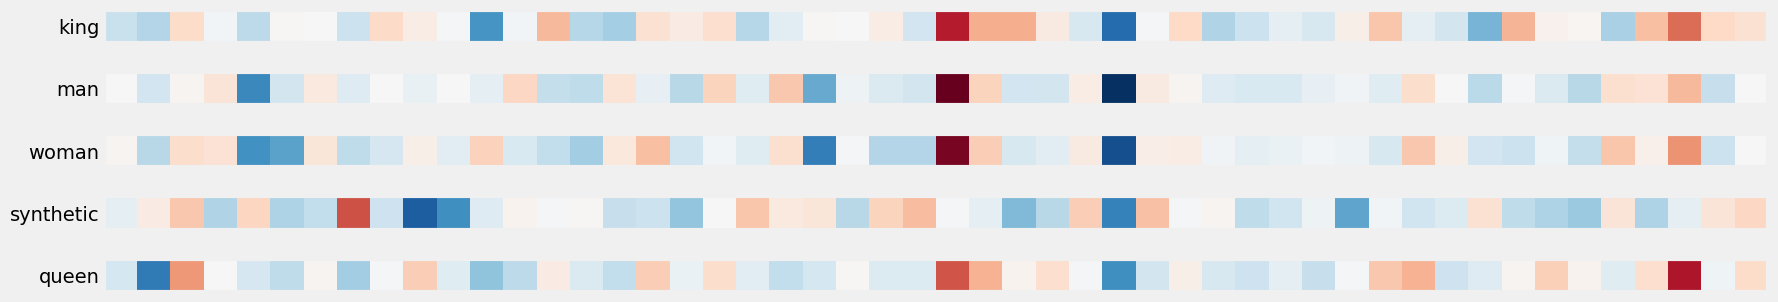

In [73]:
fig = plot_word_vectors(glove,
                        ['king', 'man', 'woman', 'synthetic', 'queen'],
                        other={'synthetic': synthetic_queen})

In [74]:
glove.similar_by_vector(synthetic_queen, topn=5)

[('king', 0.8859834671020508),
 ('queen', 0.8609582185745239),
 ('daughter', 0.7684512734413147),
 ('prince', 0.7640699744224548),
 ('throne', 0.7634970545768738)]

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/embed_arithmetic.png?raw=1)

$$
\Large
w_{\text{king}} - w_{\text{man}}\approx w_{\text{queen}}-w_{\text{woman}} \implies w_{\text{king}} - w_{\text{man}} + w_{\text{woman}} \approx w_{\text{queen}}
$$

## Using Word Embeddings

### Vocabulary Coverage

In [75]:
vocab = list(dictionary.token2id.keys())
len(vocab)

3707

In [76]:
# UPDATED
###########################################################
# The vocab property isn't available anymore at the newer
# Gensim version. It was replaced by key_to_index
# unknown_words = sorted(list(set(vocab).difference(set(glove.vocab))))

unknown_words = sorted(list(set(vocab).difference(set(glove.key_to_index))))
###########################################################
print(len(unknown_words))
print(unknown_words[:5])

42
['[PAD]', '[UNK]', 'barrowful', 'carecrow', 'comfits']


In [77]:
unknown_ids = [dictionary.token2id[w] for w in unknown_words if w not in ['[PAD]', '[UNK]']]
unknown_count = np.sum([dictionary.cfs[idx] for idx in unknown_ids])
unknown_count, dictionary.num_pos

(80, 50826)

In [78]:
def vocab_coverage(gensim_dict, pretrained_wv, special_tokens=('[PAD]', '[UNK]')):
    vocab = list(gensim_dict.token2id.keys())
    # UPDATED
    ###########################################################
    # The vocab property isn't available anymore at the newer
    # Gensim version. It was replaced by key_to_index
    # unknown_words = sorted(list(set(vocab).difference(set(pretrained_wv.vocab))))
    unknown_words = sorted(list(set(vocab).difference(set(pretrained_wv.key_to_index))))
    ###########################################################
    unknown_ids = [gensim_dict.token2id[w] for w in unknown_words if w not in special_tokens]
    unknown_count = np.sum([gensim_dict.cfs[idx] for idx in unknown_ids])
    cov = 1 - unknown_count / gensim_dict.num_pos
    return cov

In [79]:
vocab_coverage(dictionary, glove)

0.9984260024396963

### Tokenizer

In [80]:
def make_vocab_from_wv(wv, folder=None, special_tokens=None):
    if folder is not None:
        if not os.path.exists(folder):
            os.mkdir(folder)

    # UPDATED
    ###########################################################
    # The index2word property isn't available anymore at the
    # newer Gensim version. It was replaced by index_to_key
    # words = wv.index2word
    words = wv.index_to_key
    ###########################################################
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words

    with open(os.path.join(folder, 'vocab.txt'), 'w') as f:
        for word in words:
            f.write(f'{word}\n')

In [81]:
make_vocab_from_wv(glove, 'glove_vocab/', special_tokens=['[PAD]', '[UNK]'])

In [82]:
glove_tokenizer = BertTokenizer('glove_vocab/vocab.txt')

In [83]:
glove_tokenizer.encode('alice followed the white rabbit', add_special_tokens=False)

[7101, 930, 2, 300, 12427]

In [84]:
len(glove_tokenizer.vocab), len(glove.vectors)

(400002, 400000)

### Special Tokens' Embeddings

In [85]:
special_embeddings = np.zeros((2, glove.vector_size))

In [86]:
extended_embeddings = np.concatenate([special_embeddings, glove.vectors], axis=0)
extended_embeddings.shape

(400002, 50)

In [87]:
alice_idx = glove_tokenizer.encode('alice', add_special_tokens=False)
np.all(extended_embeddings[alice_idx] == glove['alice'])

True

## Model I - GloVe + Classifier

### Data Preparation

In [88]:
train_sentences = train_dataset['sentence']
train_labels = train_dataset['labels']

test_sentences = test_dataset['sentence']
test_labels = test_dataset['labels']

In [89]:
train_ids = glove_tokenizer(train_sentences,
                            truncation=True,
                            padding=True,
                            max_length=60,
                            add_special_tokens=False,
                            return_tensors='pt')['input_ids']
train_labels = torch.as_tensor(train_labels).float().view(-1, 1)

test_ids = glove_tokenizer(test_sentences,
                           truncation=True,
                           padding=True,
                           max_length=60,
                           add_special_tokens=False,
                           return_tensors='pt')['input_ids']
test_labels = torch.as_tensor(test_labels).float().view(-1, 1)

In [90]:
train_tensor_dataset = TensorDataset(train_ids, train_labels)
generator = torch.Generator()
train_loader = DataLoader(train_tensor_dataset, batch_size=32, shuffle=True, generator=generator)
test_tensor_dataset = TensorDataset(test_ids, test_labels)
test_loader = DataLoader(test_tensor_dataset, batch_size=32)

### Pre-Trained PyTorch Embeddings

In [91]:
extended_embeddings = torch.as_tensor(extended_embeddings).float()
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)

In [92]:
token_ids, labels = next(iter(train_loader))
token_ids

tensor([[  36, 1363,  287,  ...,    0,    0,    0],
        [  10,   39,   16,  ...,    0,    0,    0],
        [   7, 1423,    2,  ...,    0,    0,    0],
        ...,
        [ 934, 2400,   16,  ...,    0,    0,    0],
        [  28,  364,   17,  ...,    0,    0,    0],
        [  85,   83,   45,  ...,    0,    0,    0]])

In [93]:
token_embeddings = torch_embeddings(token_ids)
token_embeddings.shape

torch.Size([32, 60, 50])

In [94]:
token_embeddings.mean(dim=1)

tensor([[ 0.0304,  0.0309, -0.0512,  ..., -0.0346,  0.0200,  0.0797],
        [ 0.1208,  0.0620, -0.0357,  ..., -0.1315,  0.0473,  0.1333],
        [ 0.1013,  0.3428,  0.0159,  ..., -0.2509,  0.0620, -0.0068],
        ...,
        [ 0.0431,  0.0986, -0.0392,  ..., -0.0608,  0.0285,  0.0397],
        [ 0.0324,  0.0149, -0.0068,  ..., -0.0543,  0.0004, -0.0527],
        [ 0.2350,  0.1445, -0.1068,  ..., -0.1654, -0.0325,  0.0180]])

In [95]:
boe_mean = nn.EmbeddingBag.from_pretrained(extended_embeddings, mode='mean')
boe_mean(token_ids)

tensor([[ 0.0304,  0.0309, -0.0512,  ..., -0.0346,  0.0200,  0.0797],
        [ 0.1208,  0.0620, -0.0357,  ..., -0.1315,  0.0473,  0.1333],
        [ 0.1013,  0.3428,  0.0159,  ..., -0.2509,  0.0620, -0.0068],
        ...,
        [ 0.0431,  0.0986, -0.0392,  ..., -0.0608,  0.0285,  0.0397],
        [ 0.0324,  0.0149, -0.0068,  ..., -0.0543,  0.0004, -0.0527],
        [ 0.2350,  0.1445, -0.1068,  ..., -0.1654, -0.0325,  0.0180]])

### Model Configuration & Training

In [96]:
extended_embeddings = torch.as_tensor(extended_embeddings).float()
boe_mean = nn.EmbeddingBag.from_pretrained(
    extended_embeddings, mode='mean'
)
torch.manual_seed(41)
model = nn.Sequential(
    # Embeddings
    boe_mean,
    # Classifier
    nn.Linear(boe_mean.embedding_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [97]:
sbs_emb = StepByStep(model, loss_fn, optimizer)
sbs_emb.set_loaders(train_loader, test_loader)
sbs_emb.train(20)

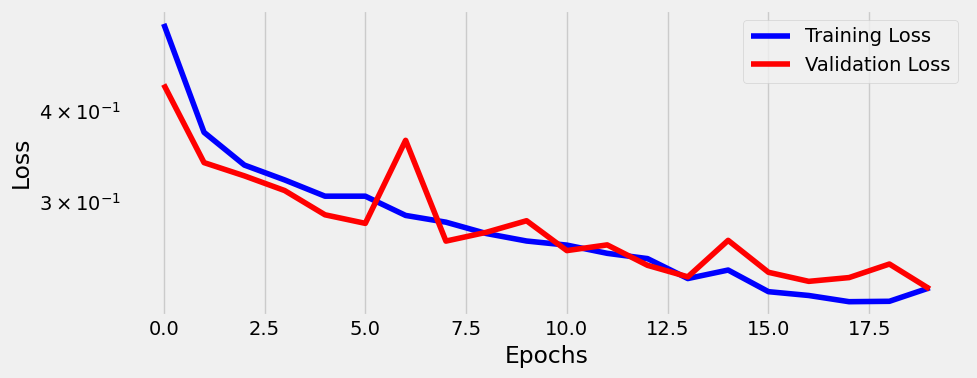

In [98]:
fig = sbs_emb.plot_losses()

In [99]:
StepByStep.loader_apply(test_loader, sbs_emb.correct)

tensor([[414, 449],
        [288, 322]])

## Model II - GloVe + Transformer

In [100]:
class TransfClassifier(nn.Module):
    def __init__(self, embedding_layer, encoder, n_outputs):
        super().__init__()
        self.d_model = encoder.d_model
        self.n_outputs = n_outputs
        self.encoder = encoder
        self.mlp = nn.Linear(self.d_model, n_outputs)

        self.embed = embedding_layer
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.d_model))

    def preprocess(self, X):
        # N, L -> N, L, D
        src = self.embed(X)
        # Special classifier token
        # 1, 1, D -> N, 1, D
        cls_tokens = self.cls_token.expand(X.size(0), -1, -1)
        # Concatenates CLS tokens -> N, 1 + L, D
        src = torch.cat((cls_tokens, src), dim=1)
        return src

    def encode(self, source, source_mask=None):
        # Encoder generates "hidden states"
        states = self.encoder(source, source_mask)
        # Gets state from first token only: [CLS]
        cls_state = states[:, 0]  # N, 1, D
        return cls_state

    @staticmethod
    def source_mask(X):
        cls_mask = torch.ones(X.size(0), 1).type_as(X)
        pad_mask = torch.cat((cls_mask, X > 0), dim=1).bool()
        return pad_mask.unsqueeze(1)

    def forward(self, X):
        src = self.preprocess(X)
        # Featurizer
        cls_state = self.encode(src, self.source_mask(X))
        # Classifier
        out = self.mlp(cls_state) # N, 1, outputs
        return out

In [101]:
torch.manual_seed(33)
# Loads the pretrained GloVe embeddings into an embedding layer
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=2, d_model=torch_embeddings.embedding_dim, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1)
# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [102]:
sbs_transf = StepByStep(model, loss_fn, optimizer)
sbs_transf.set_loaders(train_loader, test_loader)
sbs_transf.train(10)

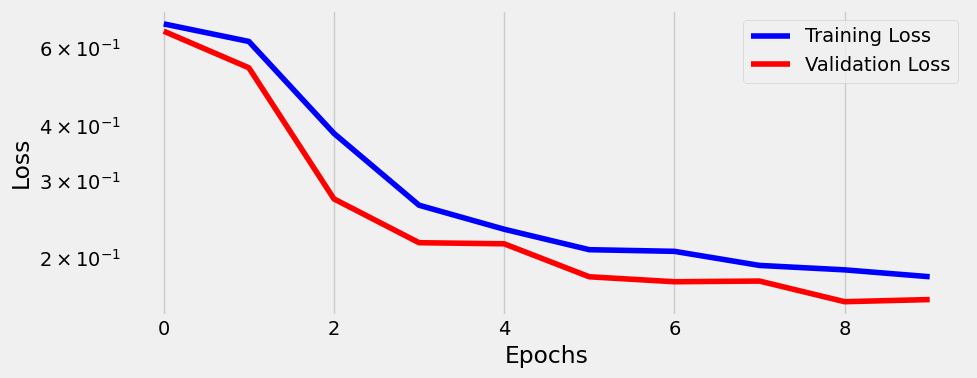

In [103]:
fig = sbs_transf.plot_losses()

In [104]:
StepByStep.loader_apply(test_loader, sbs_transf.correct)

tensor([[425, 449],
        [290, 322]])

### Visualizing Attention

In [105]:
sentences = ['The white rabbit and Alice ran away', 'The lion met Dorothy on the road']
inputs = glove_tokenizer(sentences, add_special_tokens=False, return_tensors='pt')['input_ids']
inputs = inputs.to(sbs_transf.device)
inputs

tensor([[    2,   300, 12427,     7,  7101,  1423,   422],
        [    2,  6659,   811, 11238,    15,     2,   588]], device='cuda:0')

In [106]:
sbs_transf.model.eval()
out = sbs_transf.model(inputs)
# our model outputs logits, so we turn them into probs
torch.sigmoid(out)

tensor([[0.9891],
        [0.0092]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [107]:
alphas = sbs_transf.model.encoder.layers[0].self_attn_heads.alphas
alphas[:, :, 0, :].squeeze()

tensor([[[2.5707e-01, 7.0586e-02, 2.2622e-01, 1.3485e-01, 1.1331e-01,
          1.3022e-01, 5.3373e-02, 1.4372e-02],
         [5.2963e-05, 2.9660e-03, 4.4199e-03, 7.5878e-02, 4.0270e-03,
          9.1002e-01, 1.1697e-03, 1.4623e-03]],

        [[6.7323e-02, 1.8485e-02, 8.2055e-02, 6.4121e-02, 6.2406e-01,
          1.1057e-02, 1.6442e-02, 1.1645e-01],
         [3.7875e-04, 2.1211e-02, 2.4569e-01, 4.0334e-02, 5.9883e-01,
          4.3009e-02, 2.5408e-02, 2.5134e-02]]], device='cuda:0')

/content/plots/chapter11.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', f'Head #{i}', ''])
/content/plots/chapter11.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', f'Head #{i}', ''])
/content/plots/chapter11.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', f'Head #{i}', ''])
/content/plots/chapter11.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', f'Head #{i}', ''])


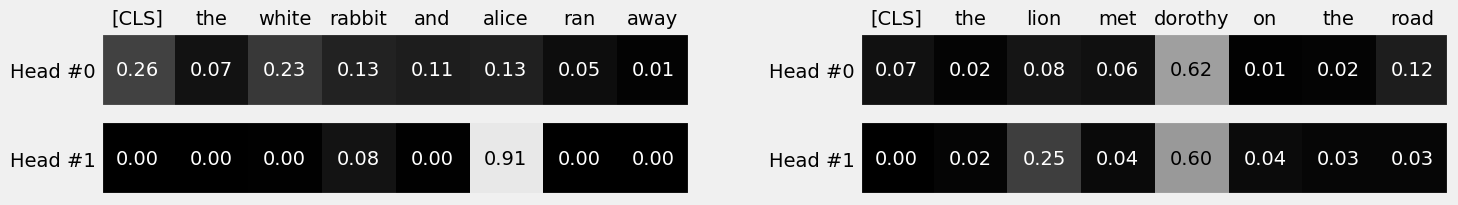

In [108]:
tokens = [['[CLS]'] + glove_tokenizer.tokenize(sent) for sent in sentences]
fig = plot_attention(tokens, alphas)

# Contextual Word Embeddings

## ELMo

In [109]:
watch1 = """
The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.
"""

watch2 = """
Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!
"""

sentences = [watch1, watch2]

In [110]:
from flair.data import Sentence

flair_sentences = [Sentence(s) for s in sentences]
flair_sentences[0]

Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear."

In [111]:
flair_sentences[0].get_token(32)

Token[31]: "watch"

In [112]:
flair_sentences[0].tokens[31]

Token[31]: "watch"

In [113]:
# UPDATED
###########################################################
# Unfortunately, ELMO embeddings were returned by flair
# using the allennlp library that has been archived.
# from flair.embeddings import ELMoEmbeddings
# elmo = ELMoEmbeddings()

# As replacement, we'll be using flair's own embeddings instead
from flair.embeddings import FlairEmbeddings
flair_emb = FlairEmbeddings('news-forward')
###########################################################

In [114]:
# UPDATED
###########################################################
# Instead of elmo, embeds sentences using flair embeddings
# elmo.embed(flair_sentences)
flair_emb.embed(flair_sentences)
###########################################################

[Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.",
 Sentence[48]: " Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!"]

In [115]:
token_watch1 = flair_sentences[0].tokens[31]
token_watch2 = flair_sentences[1].tokens[13]
token_watch1, token_watch2

(Token[31]: "watch", Token[13]: "watch")

In [116]:
token_watch1.embedding, token_watch2.embedding

(tensor([-0.0007, -0.0057,  0.0187,  ..., -0.0051, -0.0022,  0.0026],
        device='cuda:0'),
 tensor([-0.0011, -0.0037,  0.1031,  ..., -0.0079, -0.0044,  0.0002],
        device='cuda:0'))

### Where do ELMo Embeddings come from?

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/elmo_lstm.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/elmo_embed.png?raw=1)

In [117]:
# UPDATED
###########################################################
# Unfortunately, this piece of code only makes sense for
# ELMO embeddings. Flair embeddings are structured differently
# and therefore this code is commented out.
# token_watch1.embedding[0], token_watch1.embedding[512]
###########################################################

In [118]:
# UPDATED
###########################################################
# Unfortunately, this piece of code only makes sense for
# ELMO embeddings. Flair embeddings are structured differently
# and therefore this code is commented out.
# (token_watch1.embedding[:1024] == token_watch2.embedding[:1024]).all()
###########################################################

In [119]:
similarity = nn.CosineSimilarity(dim=0, eps=1e-6)
similarity(token_watch1.embedding, token_watch2.embedding)

tensor(0.5003, device='cuda:0')

In [120]:
def get_embeddings(embeddings, sentence):
    sent = Sentence(sentence)
    embeddings.embed(sent)
    return torch.stack([token.embedding for token in sent.tokens]).float()

In [121]:
# UPDATED
###########################################################
# Instead of elmo, embeds sentences using flair embeddings
# get_embeddings(elmo, watch1)
get_embeddings(flair_emb, watch1)
###########################################################

tensor([[-2.0933e-03,  5.0415e-04,  4.6944e-02,  ..., -4.4014e-04,
         -3.9301e-02,  1.0601e-02],
        [ 3.2224e-04,  1.4939e-03,  2.5947e-02,  ..., -9.2415e-04,
         -1.4211e-02,  3.0942e-03],
        [ 1.7407e-03, -1.8324e-04,  5.3375e-02,  ...,  4.5165e-04,
          5.4484e-02,  9.7125e-03],
        ...,
        [ 2.2250e-03,  2.2138e-04,  4.4385e-02,  ..., -3.9766e-03,
         -7.9449e-04,  2.2444e-02],
        [-2.2455e-03,  9.7197e-04,  3.4624e-02,  ..., -7.1559e-05,
          1.2647e-02,  1.3210e-02],
        [ 1.0997e-03,  8.4726e-05,  1.5534e-01,  ..., -1.5737e-04,
          9.5801e-04,  5.3785e-03]], device='cuda:0')

## GloVe

In [122]:
from flair.embeddings import WordEmbeddings
glove_embedding = WordEmbeddings('glove')

In [123]:
new_flair_sentences = [Sentence(s) for s in sentences]
glove_embedding.embed(new_flair_sentences)

[Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.",
 Sentence[48]: " Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!"]

In [124]:
torch.all(new_flair_sentences[0].tokens[31].embedding == new_flair_sentences[1].tokens[13].embedding)

tensor(True, device='cuda:0')

## BERT

In [125]:
from flair.embeddings import TransformerWordEmbeddings
bert_flair = TransformerWordEmbeddings('bert-base-uncased', layers='-1')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [126]:
embed1 = get_embeddings(bert_flair, watch1)
embed2 = get_embeddings(bert_flair, watch2)
embed2

tensor([[ 0.6554, -0.3799, -0.2842,  ...,  0.0601,  0.8865,  0.4760],
        [-0.1459, -0.0204, -0.0615,  ..., -0.0257,  0.5052,  0.3324],
        [-0.0436, -0.0400, -0.0135,  ...,  0.3920,  0.5231,  0.9067],
        ...,
        [-0.2582,  0.6933,  0.2688,  ..., -0.0325,  0.0772,  0.2187],
        [-0.1868,  0.6398, -0.8127,  ..., -0.5957,  0.2793,  0.1880],
        [-0.1021,  0.5222, -0.7142,  ...,  0.3644,  0.0600, -0.1419]],
       device='cuda:0')

In [127]:
bert_watch1 = embed1[31]
bert_watch2 = embed2[13]
bert_watch1, bert_watch2

(tensor([ 8.5760e-01,  3.5888e-01, -3.7825e-01, -8.3564e-01,  1.3528e+00,
          1.0204e-01, -8.2618e-01,  3.1570e-01,  3.1091e-01, -4.2653e-01,
          1.6632e-01,  7.2440e-02, -1.0276e+00,  4.4680e-01, -1.4549e-01,
          1.8315e-01,  3.7484e-01, -4.0245e-01, -1.4190e-01, -5.1596e-01,
          1.1984e+00,  6.8202e-01,  1.1028e+00, -4.3956e-02,  1.6932e-02,
          7.4420e-01, -1.0604e-01,  3.8719e-01,  7.3662e-02,  2.2424e-01,
         -5.0282e-02,  1.9586e-01,  1.0773e+00,  1.0341e+00,  4.4217e-01,
         -6.5567e-01, -5.6308e-01, -1.1827e-01,  1.2862e-01,  4.6581e-01,
         -7.1305e-01, -1.5682e-01, -1.3552e-01,  4.5852e-02,  8.2852e-03,
          5.2762e-01,  1.6906e+00,  5.5388e-01, -7.3777e-02,  5.1504e-01,
         -2.0619e-01, -2.9503e-03,  2.5389e-01, -1.5379e-01,  8.4900e-01,
          6.5440e-01, -3.2925e-01, -1.1198e+00,  2.4251e-01,  1.5586e-01,
          5.7514e-01,  8.5832e-02,  3.3306e-01, -3.9344e-01, -4.1766e-01,
          1.0790e+00,  1.1719e-02,  7.

In [128]:
similarity = nn.CosineSimilarity(dim=0, eps=1e-6)
similarity(bert_watch1, bert_watch2)

tensor(0.3504, device='cuda:0')

## Document Embeddings

In [129]:
documents = [Sentence(watch1), Sentence(watch2)]

In [130]:
from flair.embeddings import TransformerDocumentEmbeddings
bert_doc = TransformerDocumentEmbeddings('bert-base-uncased')
bert_doc.embed(documents)

[Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.",
 Sentence[48]: " Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!"]

In [131]:
documents[0].embedding

tensor([-6.4245e-02,  3.5365e-01, -2.4962e-01, -5.3912e-01, -1.9917e-01,
        -2.7712e-01,  1.6942e-01,  1.0867e-01, -4.0799e-01, -1.4945e-01,
         4.4678e-02, -1.9687e-01, -3.0574e-01,  9.6215e-02,  2.8053e-01,
         9.0462e-01, -3.0250e-01,  1.7854e-01, -1.6856e-01, -1.7227e-01,
        -1.8270e-01,  4.5121e-01,  3.6129e-01,  1.2309e-01, -1.2047e-02,
        -5.0255e-01,  4.2645e-01, -3.7184e-02, -1.7052e-01, -4.8920e-02,
         1.0503e-01,  3.3456e-01, -3.8483e-02, -4.7287e-01, -7.4431e-02,
         2.3990e-01, -8.3232e-02,  1.7974e-01,  4.8939e-01,  9.3026e-03,
        -4.2722e-01,  2.6337e-01, -1.3217e-01, -1.3950e-01, -1.1859e-01,
         4.5835e-02, -3.9031e+00, -1.0726e-01,  5.1103e-02, -9.9710e-02,
         1.5913e-01, -9.5331e-02,  2.1513e-01,  4.7707e-01,  2.1226e-01,
         4.3450e-01, -4.5154e-01,  1.8344e-01, -1.0171e-01, -3.6373e-01,
         8.9560e-01,  3.5931e-01, -2.8519e-01,  2.9427e-02,  3.3968e-01,
         4.1062e-01, -2.1051e-02,  2.7801e-02,  2.8

In [132]:
documents[0].tokens[31].embedding

tensor([], device='cuda:0')

In [133]:
def get_embeddings(embeddings, sentence):
    sent = Sentence(sentence)
    embeddings.embed(sent)
    if len(sent.embedding):
        return sent.embedding.float()
    else:
        return torch.stack([token.embedding for token in sent.tokens]).float()

In [134]:
get_embeddings(bert_doc, watch1)

tensor([-6.4245e-02,  3.5365e-01, -2.4962e-01, -5.3912e-01, -1.9917e-01,
        -2.7712e-01,  1.6942e-01,  1.0867e-01, -4.0799e-01, -1.4945e-01,
         4.4679e-02, -1.9687e-01, -3.0574e-01,  9.6215e-02,  2.8053e-01,
         9.0462e-01, -3.0250e-01,  1.7854e-01, -1.6856e-01, -1.7227e-01,
        -1.8270e-01,  4.5121e-01,  3.6128e-01,  1.2309e-01, -1.2047e-02,
        -5.0255e-01,  4.2645e-01, -3.7184e-02, -1.7052e-01, -4.8920e-02,
         1.0503e-01,  3.3456e-01, -3.8483e-02, -4.7287e-01, -7.4431e-02,
         2.3990e-01, -8.3232e-02,  1.7974e-01,  4.8939e-01,  9.3027e-03,
        -4.2722e-01,  2.6337e-01, -1.3217e-01, -1.3950e-01, -1.1859e-01,
         4.5834e-02, -3.9031e+00, -1.0726e-01,  5.1103e-02, -9.9710e-02,
         1.5913e-01, -9.5331e-02,  2.1513e-01,  4.7707e-01,  2.1226e-01,
         4.3450e-01, -4.5154e-01,  1.8344e-01, -1.0171e-01, -3.6373e-01,
         8.9560e-01,  3.5931e-01, -2.8519e-01,  2.9427e-02,  3.3968e-01,
         4.1062e-01, -2.1051e-02,  2.7801e-02,  2.8

## Model III - Preprocessing Embeddings

### Data Preparation

In [196]:
train_dataset_doc = train_dataset.map(lambda row: {'embeddings': get_embeddings(bert_doc, row['sentence'])})
test_dataset_doc = test_dataset.map(lambda row: {'embeddings': get_embeddings(bert_doc, row['sentence'])})

In [197]:
train_dataset_doc.set_format(type='torch', columns=['embeddings', 'labels'])
test_dataset_doc.set_format(type='torch', columns=['embeddings', 'labels'])

In [198]:
train_dataset_doc['embeddings']

tensor([[ 0.2939,  0.3620, -0.0109,  ..., -0.1065,  0.4953,  0.4308],
        [ 0.0246,  0.2661, -0.3555,  ...,  0.2206,  0.7003,  0.4276],
        [ 0.2284, -0.0560, -0.3010,  ...,  0.2766,  0.3554,  0.3978],
        ...,
        [-0.1394,  0.1298, -0.1915,  ..., -0.0798,  0.3269,  0.3746],
        [-0.3726,  0.3462, -0.3327,  ...,  0.3237,  0.7560,  0.2751],
        [ 0.2105,  0.1443, -0.3271,  ...,  0.4474,  0.5367,  0.3423]])

In [199]:
train_dataset_doc = TensorDataset(train_dataset_doc['embeddings'].float(),
                                  train_dataset_doc['labels'].view(-1, 1).float())
generator = torch.Generator()
train_loader = DataLoader(train_dataset_doc, batch_size=32, shuffle=True, generator=generator)

test_dataset_doc = TensorDataset(test_dataset_doc['embeddings'].float(),
                                 test_dataset_doc['labels'].view(-1, 1).float())
test_loader = DataLoader(test_dataset_doc, batch_size=32, shuffle=True)

### Model Configuration & Training

In [280]:
torch.manual_seed(41)
middle_dim = 3
model = nn.Sequential(
    # Classifier
    nn.Linear(bert_doc.embedding_length, middle_dim),
    nn.ReLU(),
    nn.Linear(middle_dim, 1)
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
sbs_doc_emb = StepByStep(model, loss_fn, optimizer)
sbs_doc_emb.set_loaders(train_loader, test_loader)
sbs_doc_emb.train(10)

tensor([[431, 449],
        [301, 322]])


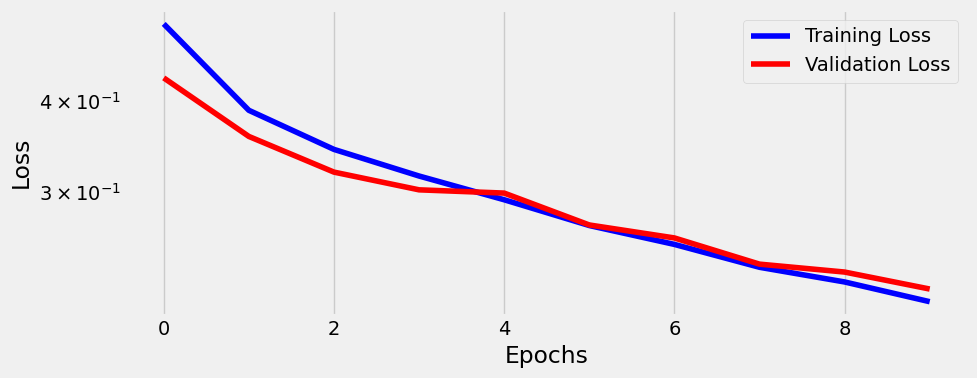

In [223]:
fig = sbs_doc_emb.plot_losses()
print(StepByStep.loader_apply(test_loader, sbs_doc_emb.correct))

# BERT

In [281]:
from transformers import AutoModel
auto_model = AutoModel.from_pretrained('bert-base-uncased')
print(auto_model.__class__)

<class 'transformers.models.bert.modeling_bert.BertModel'>


In [282]:
from transformers import BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [283]:
bert_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Tokenization

In [284]:
from transformers import BertTokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
len(bert_tokenizer.vocab)

30522

In [295]:
sentence1 = 'Alice is inexplicably following the white rabbit'
sentence2 = 'Follow the white rabbit, Neo'
tokens = bert_tokenizer(sentence1, sentence2, return_tensors='pt')
tokens

{'input_ids': tensor([[  101,  5650,  2003,  1999, 10288, 24759,  5555,  6321,  2206,  1996,
          2317, 10442,   102,  3582,  1996,  2317, 10442,  1010,  9253,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [301]:
tokens = tokens.to(device)

In [287]:
print(bert_tokenizer.convert_ids_to_tokens(tokens['input_ids'][0]))

['[CLS]', 'alice', 'is', 'in', '##ex', '##pl', '##ica', '##bly', 'following', 'the', 'white', 'rabbit', '[SEP]', 'follow', 'the', 'white', 'rabbit', ',', 'neo', '[SEP]']


In [288]:
from transformers import AutoTokenizer
auto_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
print(auto_tokenizer.__class__)

<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


## Input Embeddings

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/bert_input_embed.png?raw=1)

In [302]:
input_embeddings = bert_model.embeddings.to(device)
input_embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [297]:
token_embeddings = input_embeddings.word_embeddings
token_embeddings

Embedding(30522, 768, padding_idx=0)

In [304]:
input_token_emb = token_embeddings(tokens['input_ids'])
input_token_emb.shape

torch.Size([1, 20, 768])

In [307]:
position_embeddings = input_embeddings.position_embeddings
position_embeddings

Embedding(512, 768)

In [308]:
position_ids = torch.arange(512).expand((1, -1)).to(device)
position_ids

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 173, 174, 175, 176

In [309]:
seq_length = tokens['input_ids'].size(1)
input_pos_emb = position_embeddings(position_ids[:, :seq_length])
input_pos_emb.shape

torch.Size([1, 20, 768])

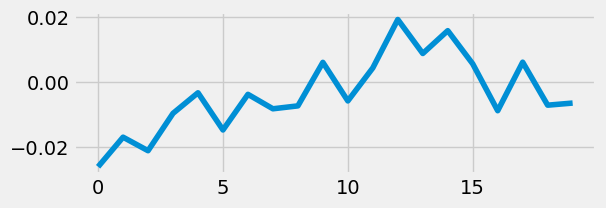

In [273]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6,2))
t_id = 3
plt.plot(input_pos_emb[0,:,t_id].detach().cpu().numpy())
plt.show()

In [310]:
segment_embeddings = input_embeddings.token_type_embeddings
segment_embeddings

Embedding(2, 768)

In [316]:
input_pos_emb[0,:,0:5].std(dim=0)

tensor([0.0093, 0.0120, 0.0091, 0.0117, 0.0059], device='cuda:0',
       grad_fn=<StdBackward0>)

In [317]:
input_token_emb[0,:,0:5].std(dim=0)

tensor([0.0294, 0.0305, 0.0242, 0.0208, 0.0302], device='cuda:0',
       grad_fn=<StdBackward0>)

In [318]:
input_seg_emb = segment_embeddings(tokens['token_type_ids'])
input_seg_emb

tensor([[[ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
         [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
         [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
         ...,
         [ 0.0011, -0.0030, -0.0032,  ...,  0.0047, -0.0052, -0.0112],
         [ 0.0011, -0.0030, -0.0032,  ...,  0.0047, -0.0052, -0.0112],
         [ 0.0011, -0.0030, -0.0032,  ...,  0.0047, -0.0052, -0.0112]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [319]:
input_emb = input_token_emb + input_pos_emb + input_seg_emb
input_emb

tensor([[[ 0.0316, -0.0411, -0.0564,  ...,  0.0021,  0.0044,  0.0219],
         [-0.0615, -0.0750, -0.0107,  ...,  0.0364,  0.0482, -0.0277],
         [-0.0469, -0.0156, -0.0336,  ...,  0.0117,  0.0135,  0.0109],
         ...,
         [-0.0081, -0.0051, -0.0172,  ...,  0.0542, -0.0103,  0.0083],
         [-0.0425, -0.0756, -0.0414,  ..., -0.0252, -0.0180, -0.0060],
         [-0.0138, -0.0138, -0.0194,  ...,  0.0032, -0.0011, -0.0133]]],
       device='cuda:0', grad_fn=<AddBackward0>)

## Pretraining Tasks

### Masked Language Model (MLM)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/bert_mlm.png?raw=1)

In [159]:
sentence = 'Alice is inexplicably following the white rabbit'
tokens = bert_tokenizer(sentence)
tokens['input_ids']

[101, 5650, 2003, 1999, 10288, 24759, 5555, 6321, 2206, 1996, 2317, 10442, 102]

In [160]:
from transformers import DataCollatorForLanguageModeling
torch.manual_seed(41)
data_collator = DataCollatorForLanguageModeling(tokenizer=bert_tokenizer, mlm_probability=0.15)
mlm_tokens = data_collator([tokens])
mlm_tokens

{'input_ids': tensor([[  101,  5650,  2003,  1999, 10288, 24759,   103,  6321,  2206,  1996,
          2317, 10442,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[-100, -100, -100, -100, -100, -100, 5555, -100, -100, -100, -100, -100,
         -100]])}

In [161]:
print(bert_tokenizer.convert_ids_to_tokens(tokens['input_ids']))
print(bert_tokenizer.convert_ids_to_tokens(mlm_tokens['input_ids'][0]))

['[CLS]', 'alice', 'is', 'in', '##ex', '##pl', '##ica', '##bly', 'following', 'the', 'white', 'rabbit', '[SEP]']
['[CLS]', 'alice', 'is', 'in', '##ex', '##pl', '[MASK]', '##bly', 'following', 'the', 'white', 'rabbit', '[SEP]']


### Next Sentence Prediction (NSP)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/bert_nsp.png?raw=1)

In [162]:
bert_model.pooler

BertPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

In [163]:
sentence1 = 'alice follows the white rabbit'
sentence2 = 'follow the white rabbit neo'
bert_tokenizer(sentence1, sentence2, return_tensors='pt')

{'input_ids': tensor([[  101,  5650,  4076,  1996,  2317, 10442,   102,  3582,  1996,  2317,
         10442,  9253,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

## Outputs

In [164]:
sentence = train_dataset[0]['sentence']
sentence

'They walked back to the road.'

In [165]:
tokens = bert_tokenizer(sentence,
                        padding='max_length',
                        max_length=30,
                        truncation=True,
                        return_tensors="pt")
tokens

{'input_ids': tensor([[ 101, 2027, 2939, 2067, 2000, 1996, 2346, 1012,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]])}

In [166]:
bert_model.eval()
out = bert_model(input_ids=tokens['input_ids'],
                 attention_mask=tokens['attention_mask'],
                 output_attentions=True,
                 output_hidden_states=True,
                 return_dict=True)
out.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/bert_embeddings.png?raw=1)

In [167]:
last_hidden_batch = out['last_hidden_state']
last_hidden_sentence = last_hidden_batch[0]
# Removes hidden states for [PAD] tokens using the mask
mask = tokens['attention_mask'].squeeze().bool()
embeddings = last_hidden_sentence[mask]
# Removes embeddings for the first [CLS] and last [SEP] tokens
embeddings[1:-1]

tensor([[ 0.6598,  0.3917, -0.0364,  ...,  0.0151,  1.0337, -0.0803],
        [ 0.8864,  0.0588,  0.1100,  ...,  0.0456,  0.1382, -0.0662],
        [ 0.4361,  0.0337,  0.0071,  ...,  0.2814,  0.2284, -0.2640],
        ...,
        [ 0.5471,  0.2523, -0.5454,  ..., -0.1005,  0.4525,  0.1288],
        [ 0.8299,  0.0757,  0.1301,  ..., -0.1341, -0.0661,  0.1768],
        [ 0.9105,  0.2523, -0.4685,  ...,  0.2981, -0.0403, -0.4670]],
       grad_fn=<SliceBackward0>)

In [168]:
get_embeddings(bert_flair, sentence)

tensor([[ 0.6598,  0.3917, -0.0364,  ...,  0.0151,  1.0337, -0.0803],
        [ 0.8864,  0.0588,  0.1100,  ...,  0.0456,  0.1382, -0.0662],
        [ 0.4361,  0.0337,  0.0071,  ...,  0.2814,  0.2284, -0.2640],
        ...,
        [ 0.5471,  0.2523, -0.5454,  ..., -0.1005,  0.4525,  0.1288],
        [ 0.8299,  0.0757,  0.1301,  ..., -0.1341, -0.0661,  0.1768],
        [ 0.9105,  0.2523, -0.4685,  ...,  0.2981, -0.0403, -0.4670]],
       device='cuda:0')

In [169]:
print(len(out['hidden_states']))
print(out['hidden_states'][0].shape)

13
torch.Size([1, 30, 768])


In [170]:
(out['hidden_states'][0] == bert_model.embeddings(tokens['input_ids'])).all()

tensor(True)

In [171]:
(out['hidden_states'][-1] == out['last_hidden_state']).all()

tensor(True)

In [172]:
(out['pooler_output'] == bert_model.pooler(out['last_hidden_state'])).all()

tensor(True)

In [173]:
print(len(out['attentions']))
print(out['attentions'][0].shape)

12
torch.Size([1, 12, 30, 30])


## Model IV - Classifying using BERT

In [174]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, ff_units, n_outputs, dropout=0.3):
        super().__init__()
        self.d_model = bert_model.config.dim
        self.n_outputs = n_outputs
        self.encoder = bert_model
        self.mlp = nn.Sequential(
            nn.Linear(self.d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, n_outputs)
        )

    def encode(self, source, source_mask=None):
        states = self.encoder(input_ids=source,
                              attention_mask=source_mask)[0]
        cls_state = states[:, 0]
        return cls_state

    def forward(self, X):
        source_mask = (X > 0)
        # Featurizer
        cls_state = self.encode(X, source_mask)
        # Classifier
        out = self.mlp(cls_state)
        return out

### Data Preparation

In [175]:
def tokenize_dataset(hf_dataset, sentence_field, label_field, tokenizer, **kwargs):
    sentences = hf_dataset[sentence_field]
    token_ids = tokenizer(sentences, return_tensors='pt', **kwargs)['input_ids']
    labels = torch.as_tensor(hf_dataset[label_field])
    dataset = TensorDataset(token_ids, labels)
    return dataset

In [176]:
auto_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer_kwargs = dict(truncation=True, padding=True, max_length=30, add_special_tokens=True)

In [177]:
train_dataset_float = train_dataset.map(lambda row: {'labels': [float(row['labels'])]})
test_dataset_float = test_dataset.map(lambda row: {'labels': [float(row['labels'])]})

train_tensor_dataset = tokenize_dataset(train_dataset_float, 'sentence', 'labels', auto_tokenizer, **tokenizer_kwargs)
test_tensor_dataset = tokenize_dataset(test_dataset_float, 'sentence', 'labels', auto_tokenizer, **tokenizer_kwargs)

generator = torch.Generator()
train_loader = DataLoader(train_tensor_dataset, batch_size=4, shuffle=True, generator=generator)
test_loader = DataLoader(test_tensor_dataset, batch_size=8)

Map:   0%|          | 0/3081 [00:00<?, ? examples/s]

Map:   0%|          | 0/771 [00:00<?, ? examples/s]

### Model Configuration & Training

In [178]:
torch.manual_seed(41)
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")
model = BERTClassifier(bert_model, 128, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [179]:
sbs_bert = StepByStep(model, loss_fn, optimizer)
sbs_bert.set_loaders(train_loader, test_loader)
sbs_bert.train(1)

In [180]:
sbs_bert.count_parameters()

66461441

In [181]:
StepByStep.loader_apply(test_loader, sbs_bert.correct)

tensor([[438, 449],
        [312, 322]])

# Fine-Tuning with HuggingFace

## Sequence Classification (or Regression)

In [182]:
from transformers import DistilBertForSequenceClassification
torch.manual_seed(42)
bert_cls = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

In [183]:
from transformers import AutoModelForSequenceClassification
auto_cls = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
print(auto_cls.__class__)

<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>


## Tokenized Dataset

In [184]:
auto_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize(row):
    return auto_tokenizer(row['sentence'],
                          truncation=True,
                          padding='max_length',
                          max_length=30)

In [185]:
tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/3081 [00:00<?, ? examples/s]

Map:   0%|          | 0/771 [00:00<?, ? examples/s]

In [186]:
print(tokenized_train_dataset[0])

{'sentence': 'They walked back to the road.', 'source': 'wizoz10-1740.txt', 'labels': 0, 'input_ids': [101, 2027, 2939, 2067, 2000, 1996, 2346, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [187]:
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [188]:
tokenized_train_dataset[0]

{'labels': tensor(0),
 'input_ids': tensor([ 101, 2027, 2939, 2067, 2000, 1996, 2346, 1012,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0])}

## Trainer

In [189]:
from transformers import Trainer
trainer = Trainer(model=bert_cls, train_dataset=tokenized_train_dataset)

/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [190]:
trainer.args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=True,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
gradient_checkpointing_kwargs=None,
greater_is_better=N

In [191]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='output',
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=8,
    evaluation_strategy='steps',
    eval_steps=300,
    logging_steps=300,
    gradient_accumulation_steps=8,
)

In [192]:
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [193]:
trainer = Trainer(model=bert_cls,
                  args=training_args,
                  train_dataset=tokenized_train_dataset,
                  eval_dataset=tokenized_test_dataset,
                  compute_metrics=compute_metrics)

/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [194]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:


Abort: 

In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model('bert_alice_vs_wizard')
os.listdir('bert_alice_vs_wizard')

In [ ]:
loaded_model = AutoModelForSequenceClassification.from_pretrained('bert_alice_vs_wizard')
loaded_model.device

In [ ]:

loaded_model.to(device)
loaded_model.device

## Predictions

In [ ]:
sentence = 'Down the yellow brick rabbit hole'
tokens = auto_tokenizer(sentence, return_tensors='pt')
tokens

In [ ]:
print(type(tokens))
tokens.to(loaded_model.device)

In [ ]:
loaded_model.eval()
logits = loaded_model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])
logits

In [ ]:
logits.logits.argmax(dim=1)

## Pipeline

In [ ]:
from transformers import TextClassificationPipeline
device_index = loaded_model.device.index if loaded_model.device.type != 'cpu' else -1
classifier = TextClassificationPipeline(model=loaded_model,
                                        tokenizer=auto_tokenizer,
                                        device=device_index)

In [ ]:
classifier(['Down the Yellow Brick Rabbit Hole', 'Alice rules!'])

In [ ]:
loaded_model.config.id2label = {0: 'Wizard', 1: 'Alice'}

In [ ]:
classifier(['Down the Yellow Brick Rabbit Hole', 'Alice rules!'])

## More Pipelines

In [ ]:
from transformers import pipeline
sentiment = pipeline('sentiment-analysis')

In [ ]:
sentence = train_dataset[0]['sentence']
print(sentence)
print(sentiment(sentence))

In [ ]:
from transformers.pipelines import SUPPORTED_TASKS
# UPDATED
###########################################################
# sentiment-analysis was replaced by text-classification
# in the dictionary of supported tasks
# SUPPORTED_TASKS['sentiment-analysis']
SUPPORTED_TASKS['text-classification']
###########################################################

In [ ]:
SUPPORTED_TASKS['text-generation']

# GPT-2

In [ ]:
text_generator = pipeline("text-generation")

In [ ]:
text_generator.model.config.task_specific_params

In [ ]:
base_text = """
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do:  once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,'thought Alice `without pictures or conversation?' So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
"""

In [ ]:
result = text_generator(base_text, max_length=250)
print(result[0]['generated_text'])

# Putting It All Together

## Data Preparation

In [ ]:
dataset = load_dataset(path='csv', data_files=['texts/alice28-1476.sent.csv'], quotechar='\\', split=Split.TRAIN)

In [ ]:
shuffled_dataset = dataset.shuffle(seed=42)
split_dataset = shuffled_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset, test_dataset = split_dataset['train'], split_dataset['test']

In [ ]:
auto_tokenizer = AutoTokenizer.from_pretrained('gpt2')
def tokenize(row):
    return auto_tokenizer(row['sentence'])

In [ ]:
tokenized_train_dataset = train_dataset.map(tokenize, remove_columns=['source', 'sentence'], batched=True)
tokenized_test_dataset = test_dataset.map(tokenize, remove_columns=['source', 'sentence'], batched=True)

In [ ]:
list(map(len, tokenized_train_dataset[0:6]['input_ids']))

### "Packed" Dataset

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/block_tokens.png?raw=1)

In [ ]:
# Adapted from https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_clm.py
def group_texts(examples, block_size=128):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_train_dataset = tokenized_train_dataset.map(group_texts, batched=True)
lm_test_dataset = tokenized_test_dataset.map(group_texts, batched=True)
lm_train_dataset.set_format(type='torch')
lm_test_dataset.set_format(type='torch')

In [ ]:
print(lm_train_dataset[0]['input_ids'])

In [ ]:
len(lm_train_dataset), len(lm_test_dataset)

## Model Configuration & Training

In [ ]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained('gpt2')
print(model.__class__)

In [ ]:
model.resize_token_embeddings(len(auto_tokenizer))

In [ ]:
training_args = TrainingArguments(
    output_dir='output',
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=8,
    evaluation_strategy='steps',
    eval_steps=50,
    logging_steps=50,
    gradient_accumulation_steps=4,
    prediction_loss_only=True,
)

trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=lm_train_dataset,
                  eval_dataset=lm_test_dataset)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

## Generating Text

In [ ]:
device_index = model.device.index if model.device.type != 'cpu' else -1
gpt2_gen = pipeline('text-generation', model=model, tokenizer=auto_tokenizer, device=device_index)

In [ ]:
result = gpt2_gen(base_text, max_length=250)
print(result[0]['generated_text'])